In [14]:
# load libs
%matplotlib inline
import time
import warnings
warnings.filterwarnings('ignore')

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import OneHotEncoder

In [16]:
# load and preprocess mnist
mnist = fetch_openml('mnist_784', version = 'active')
X, y = mnist.data, mnist.target
X = X.T/ 255.0
Y = OneHotEncoder().fit_transform(y.reshape(-1,1)).astype('int32').T.toarray()
X.shape, Y.shape

((784, 70000), (10, 70000))

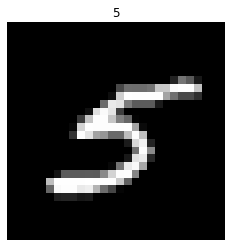

In [17]:
# make train/test splits
m = 60000
X_train, X_test = X[:,:m], X[:,m:]
Y_train, Y_test = Y[:,:m], Y[:,m:]

# shuffle
np.random.seed(123456)
shuffle = np.random.permutation(m)
X_train, Y_train = X_train[:, shuffle], Y_train[:,shuffle]

# visual check
sample = np.random.randint(m)
image = X_train[:, sample].reshape(28, -1)
plt.imshow(image, cmap = 'binary_r')
plt.title(np.argmax(Y_train[:,sample]))
plt.axis('off')
plt.show()


In [18]:
# define network

# input layer
input_depth = 1
input_height = 28
input_width = 28

## conv layer
conv_depth = 12
conv_height = 3
conv_width = 3
conv_output_height = input_height - conv_height + 1
conv_output_width  = input_width - conv_width + 1
W1 = np.random.randn(conv_depth, input_depth, conv_height, conv_width)
b1 = np.zeros((conv_depth, 1))

# fc layer
fc_dims = 4
flatten_dims = conv_depth * conv_output_height * conv_output_width
W2 = np.random.randn(fc_dims, flatten_dims)
b2 = np.zeros((fc_dims, 1))

# output
output_dims = 10
W3 = np.random.randn(output_dims, fc_dims)
b3 = np.zeros((output_dims, 1))

# prepare input
Input = X_train.reshape((1,28,28,-1))
Target = Y_train.copy()
Input.shape, Target.shape

((1, 28, 28, 60000), (10, 60000))

In [20]:
# train network

for epoch in range(10):
    
    # forward pass
    
    # conv layer: think of each val at output feature map, map(d, h ,w)
    conv_output = np.zeros((conv_depth, conv_output_height, conv_output_width, Input.shape[-1]))
    for d in range(conv_depth):
        for h in range(conv_output_height):
            for w in range(conv_output_width):
                current_patch = Input[:, h:h+conv_height,w:w+conv_width]
                current_filter = np.expand_dims(W1[d,:,:,:], axis = 3)
                conv_output[d, h, w] = (current_patch * current_filter + b1[d]).reshape(-1, Input.shape[-1]).sum(axis = 0)
                
    ## flatten
    conv_output_flatten = conv_output.reshape(-1, Input.shape[-1])
    A1 = 1 / (1 + np.exp(-conv_output_flatten))
    
    # fc
    Z2 = W2 @ A1 + b2
    A2 = 1 / (1 + np.exp(-Z2))
    
    # output layer
    Z3 = W3@A2 + b3
    Z3 = Z3 - Z3.max(axis = 0)
    A3 = np.exp(Z3)/np.exp(Z3).sum(axis = 0)
    A3 = A3 + 1e-10
    
    # Loss 
    Loss = - np.sum(Target * np.log(A3))/60000
    
    ## backward pass
    
    # ce + softmax
    dZ3 = A3 - Y_train
    dW3 = dZ3 @ A2.T / 60000
    db3 = dZ3.mean(axis = 1, keepdims = True)
    
    # fc layer
    dA2 = W3.T @ dZ3
    dZ2 = dA2 * A2 * (1 - A2)
    dW2 = dZ2 @ A1.T / 60000
    db2 = dZ2.mean(axis = 1, keepdims = True)
    
    # conv layer
    dA1 = W2.T @ dZ2
    d_conv_flatten = dA1 * A1 * (1 - A1)
    d_conv_matrix = d_conv_flatten.reshape(conv_output.shape)
    
    dW1 = np.zeros(W1.shape)
    for c1 in range(Input.shape[0]):
        for c2 in range(conv_output.shape[0]):
            for r in range(conv_height):
                for c in range(conv_width):
                    conv_input_patch = Input[c1, r:r+conv_output_height, c:c+conv_output_width, :]
                    conv_output_vals = d_conv_matrix[c2]
                    dW1[c2,c1,r,c] = np.sum(conv_input_patch * conv_output_vals)/ 60000
                    
    db1 = d_conv_matrix.sum(axis = 1).sum(axis=1).mean(axis = 1, keepdims = True)
    
    lr = 1
    W3 -= lr * dW3
    W2 -= lr * dW2
    W1 -= lr * dW1
    b3 -= lr * db3
    b2 -= lr * db2
    b1 -= lr * db1
    
    print(epoch, Loss)

0 4.30610351759765
1 2.7963288358913654
2 2.5538972753891303
3 2.4395647637731748
4 2.38419211004794
5 2.352614044691701
6 2.333479082724008
7 2.3215811444258003
8 2.3140971336129126
9 2.309365832133506
